# Parte 2

## Importo Librerias y Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [ ]:
train_transaction = pd.read_csv("/content/gdrive/MyDrive/org_datos/TP3 - MACHINE LEARNING/train_transaction.csv")
train_identity = pd.read_csv("/content/gdrive/MyDrive/org_datos/TP3 - MACHINE LEARNING/train_identity.csv")

In [ ]:
df_train = train_transaction.merge(train_identity, left_on="TransactionID", right_on="TransactionID", how="outer")
train_transaction = None
train_identity = None

In [ ]:
len(df_train.columns)

434

## Set de Train

In [ ]:
quantile_70 = df_train.TransactionDT.quantile(.7)
X_train= df_train.loc[df_train['TransactionDT'] < quantile_70]
quantile_70 = None
df_train = None

In [ ]:
X_train['TransactionDT']= X_train['TransactionDT']/60

In [ ]:
#X_test.select_dtypes(include = ["object"])

In [ ]:
low_card = ['ProductCD','card4','card6','M1','M2','M3','M4','M5','M6','M7','M8','M9','id_12','id_15','id_16','id_23','id_27','id_28','id_29','id_34','id_35','id_36','id_37','id_38'
,'DeviceType']

In [ ]:
dum_df = pd.get_dummies(X_train[low_card])

In [ ]:
columnas = list(X_train.columns.values)

for i in low_card:
  try:
    columnas.remove(i)
  except:
    print(i)
X_train = X_train[columnas]

In [ ]:
X_train = pd.concat([X_train,dum_df],axis=1)

In [ ]:
high_card = ['P_emaildomain','R_emaildomain','id_30','id_31','id_33','DeviceInfo']

In [ ]:
for i in high_card:
  Mean_encoded_subject = X_train.groupby([i])['isFraud'].mean().to_dict()
  X_train[i] =  X_train[i].map(Mean_encoded_subject)

In [ ]:
Y_train = X_train['isFraud']

In [ ]:
del X_train["isFraud"]

In [ ]:
X_train.replace(np.nan,0,inplace=True)

In [ ]:
X_train.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T,id_12_Found,id_12_NotFound,id_15_Found,id_15_New,id_15_Unknown,id_16_Found,id_16_NotFound,id_23_IP_PROXY:ANONYMOUS,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_27_Found,id_27_NotFound,id_28_Found,id_28_New,id_29_Found,id_29_NotFound,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile
0,2987000,1440.000000,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2987001,1440.016667,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,0.0,0.044041,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2987002,1441.150000,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,0.0,0.089014,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2987003,1441.650000,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,0.0,0.023649,0.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,84.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2987004,1441.766667,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,0.0,0.044041,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,1


## Set Validacion

In [ ]:
quantile_70 = df_train.TransactionDT.quantile(.7)
X_validation= df_train.loc[df_train['TransactionDT'] > quantile_70]
quantile_70 = None
df_train = None

In [ ]:
len(X_validation.columns)

434

In [ ]:
X_validation['TransactionDT']= X_validation['TransactionDT']/60

In [ ]:
dum_df = pd.get_dummies(X_validation[low_card])

columnas = list(X_validation.columns.values)

for i in low_card:
  try:
    columnas.remove(i)
  except:
    print(i)

X_validation = X_validation[columnas]

In [ ]:
X_validation = pd.concat([X_validation,dum_df],axis=1)

In [ ]:
# Muchas categorias
for i in high_card:
  X_validation[i] =  X_validation[i].map(Mean_encoded_subject)

Mean_encoded_subject=None

In [ ]:
Y_validation = X_validation['isFraud']

In [ ]:
del X_validation["isFraud"]

In [ ]:
X_validation.replace(np.nan,0,inplace=True)

In [ ]:
len(X_validation.columns)

468

In [ ]:
X_validation[["card6c_harge card","id_34_match_status:-1"]]=0

In [ ]:
len(X_validation.columns)

470

## Sets de test

In [ ]:
test_transaction = pd.read_csv("/content/gdrive/MyDrive/Orga_Datos/Data/test_transaction.csv")
test_identity = pd.read_csv("/content/gdrive/MyDrive/Orga_Datos/Data/test_identity.csv")

In [ ]:
X_test = test_transaction.merge(test_identity, left_on="TransactionID", right_on="TransactionID", how="outer")
train_transaction = None
train_identity = None

In [ ]:
X_test.columns = X_test.columns.str.replace('id-','id_')

In [ ]:
X_test['TransactionDT']= X_test['TransactionDT']/60

In [ ]:
# Pocas Categorias
low_card = ['ProductCD','card4','card6','M1','M2','M3','M4','M5','M6','M7','M8','M9','id_12','id_15','id_16','id_23','id_27','id_28','id_29','id_34','id_35','id_36','id_37','id_38'
,'DeviceType']

dum_df = pd.get_dummies(X_test[low_card])

columnas = list(X_test.columns.values)

for i in low_card:
  try:
    columnas.remove(i)
  except:
    print(i)

X_test = X_test[columnas]

In [ ]:
X_test = pd.concat([X_test,dum_df],axis=1)

In [ ]:
# Muchas categorias
for i in high_card:
  X_test[i] =  X_test[i].map(Mean_encoded_subject)

Mean_encoded_subject=None

In [ ]:
X_test[["card6_debit or credit","id_34_match_status:-1","id_34_match_status:0"]] = 0

In [ ]:
X_test.replace(np.nan,0,inplace=True)

## Fit

In [ ]:
model = LogisticRegression()

In [ ]:
# Create regularization penalty space
penalty = ["none",'l1', 'l2',"elasticnet"]

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf = RandomizedSearchCV(model,hyperparameters, n_iter=2, cv=3, random_state=1,scoring='roc_auc',n_jobs=1)

In [ ]:
result = clf.fit(X_train, Y_train)

In [ ]:
result.best_score_

0.7304403312728377

## Testear modelo con Validation

In [ ]:
print(classification_report(Y_validation, result.predict(X_validation)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    171037
           1       0.01      0.00      0.00      6125

    accuracy                           0.96    177162
   macro avg       0.49      0.50      0.49    177162
weighted avg       0.93      0.96      0.94    177162



In [ ]:
roc_auc_score(Y_validation, result.predict_proba(X_validation)[:,1])

0.7212305736925523

## Testear modelo con Test

In [ ]:
resultados = result.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
df_resultados = pd.DataFrame(resultados)

In [ ]:
resulado_final = pd.concat([X_test.TransactionID,df_resultados.iloc[:,1]], axis=1)

In [ ]:
resulado_final.head()

,TransactionID,1
0,3663549,0.047034
1,3663550,0.048702
2,3663551,0.052090
3,3663552,0.047831
4,3663553,0.048023


## Features mas importantes

In [ ]:
importance = list(result.best_estimator_.coef_[0])

In [ ]:
features = X_train.columns.values.tolist()

In [ ]:
feature_importance = pd.DataFrame({"features": features, "importance": importance, "ft_mean":X_train.mean()}).set_index('features')

In [ ]:
#feature_importance = pd.concat([feature_importance,X_train.mean()],axis=1)

In [ ]:
feature_importance["importance_v2"] = feature_importance["importance"].abs()/feature_importance.iloc[:,1]

In [ ]:
feature_importance.head()

,importance,ft_mean,importance_v2
features,,,
TransactionID,-0.000001,3.193688e+06,3.888568e-13
TransactionDT,0.000005,8.201959e+04,6.344669e-11
TransactionAmt,0.000005,1.346049e+02,3.508917e-08
card1,-0.000003,9.867096e+03,2.776220e-10
card2,-0.000002,3.578308e+02,5.978096e-09


Text(0, 0.5, 'Importancia')

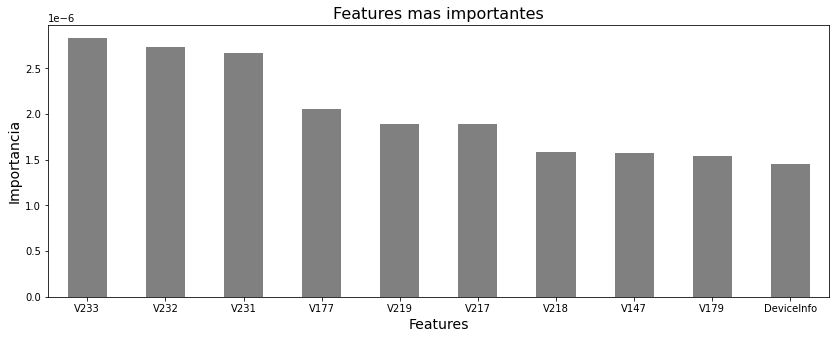

In [ ]:
feature_importance.importance_v2.nlargest(10).plot(kind='bar',figsize=[14,5],color="grey")
plt.title("Features más importantes", fontsize=16)
plt.xticks(rotation=360)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

In [ ]:
list(feature_importance.importance_v2.nlargest(20).index.values)

['V233',
 'V232',
 'V231',
 'V177',
 'V219',
 'V217',
 'V218',
 'V147',
 'V179',
 'DeviceInfo',
 'V239',
 'id_03',
 'V273',
 'V167',
 'V185',
 'V275',
 'V237',
 'V236',
 'V142',
 'id_09']